In [73]:
#Optimum filter V1, 
#removed wrapper for fit_with_shift, returns absolute index
#used the notation in Kurinsky's thesis
import numpy as np
from numpy.fft import rfft, irfft, fft, ifft, fftfreq, rfftfreq
from scipy.signal import fftconvolve

class OptimumFilter():
    
    def __init__(self, template, noise_psd, sampling_frequency):
        self._template = template
        self._noise_psd = noise_psd
        self._sampling_frequency = sampling_frequency
        self._update_state()
        
    def set_template(self, template):
        self._template = template
        self._update_state()
        
    def set_noise_psd(self, noise_psd):
        self._noise_psd = noise_psd
        self._update_state()
        
    def _update_state(self):
        self._length = len(self._template)
        
        if self._length%2==0:
            self._noise_psd_unfolded = np.concatenate(([np.inf],
                                                       self._noise_psd[1:-1]/2,
                                                       [self._noise_psd[-1]],
                                                       self._noise_psd[-2:0:-1]/2))
        else:
            self._noise_psd_unfolded = np.concatenate(([np.inf],
                                                       self._noise_psd[1:]/2,
                                                       self._noise_psd[-1:0:-1]/2))
            
        
        self._template_fft = fft(self._template)/self._sampling_frequency
        
        self._kernel_fft = self._template_fft.conjugate() / self._noise_psd_unfolded
        self._kernel_td = np.real(ifft(self._kernel_fft)) * self._sampling_frequency
        self._kernel_normalization = np.real(np.dot(self._kernel_fft, self._template_fft))*self._sampling_frequency/self._length 
        
    def fit(self, trace):

        trace_fft = fft(trace, axis=-1)/self._sampling_frequency # V
        trace_filtered = self._kernel_fft * trace_fft / self._kernel_normalization # Phi * V
        chisq0 = np.real(
            np.dot(trace_fft.conjugate()/self._noise_psd_unfolded,
                   trace_fft)*self._sampling_frequency/self._length
        )
        
        amp0 = np.real(np.sum(
            trace_filtered, axis=-1
        ))*self._sampling_frequency/self._length


        # total chisq
        # self._length-2 is the assumed number of degrees of freedom
        chisq = (chisq0 - (amp0**2)*self._kernel_normalization)/(self._length-2)
        
        return amp0, chisq
    
    def fit_with_shift(self, trace, allowed_shift_range=None):
 
        trace_fft = fft(trace, axis=-1)/self._sampling_frequency # v(f)
        trace_filtered = self._kernel_fft * trace_fft / self._kernel_normalization # \phi(f)*v(f)/normalization factor
        trace_filtered_td = np.real(
            ifft(trace_filtered, axis=-1)
        ) * self._sampling_frequency

        chi0 = np.real(
            np.dot(trace_fft.conjugate()/self._noise_psd_unfolded,
                   trace_fft)*self._sampling_frequency/self._length
        )

        chit_withdelay = (trace_filtered_td**2) * self._kernel_normalization
        chi = chi0 - chit_withdelay
        
        if allowed_shift_range is None:
            ind = np.arange(len(chi))
        else:
            ind = np.concatenate((np.arange(self._length+allowed_shift_range[0], self._length),
                                  np.arange(allowed_shift_range[1]+1)))
        
        best_ind = ind[np.argmin(chi[ind], axis=-1)]
        
        amp = trace_filtered_td[best_ind]
        chisq = chi[best_ind]/(self._length-3)
        t0 = best_ind
        
        return trace_filtered_td
        #return amp, chisq, t0

    def rolling_fit_with_shift(self, trace_long, allowed_shift_range=None):
        L = len(trace_long)
        N = self._length
        fs = self._sampling_frequency

        n_windows = L // N
        amps = np.zeros(n_windows)
        chisqs = np.zeros(n_windows)
        shifts = np.zeros(n_windows, dtype=int)
        positions = np.zeros(n_windows, dtype=int)

        for i in range(n_windows):
            start = i * N
            segment = trace_long[start:start + N]
            amp, chisq, t0 = self.fit_with_shift(segment, allowed_shift_range)

            amps[i] = amp
            chisqs[i] = chisq
            shifts[i] = t0
            positions[i] = start + t0

        return amps, chisqs, shifts, positions
    
    
    def convolve_long_trace(self, trace_long):
        filtered_trace = fftconvolve(trace_long, self._kernel_td[::-1], mode='valid') / self._kernel_normalization
        return len(self._kernel_td), filtered_trace


In [75]:
import yaml
import numpy as np
from trace_IO import *
from TraceSimulator import LongTraceSimulator
import matplotlib.pyplot as plt
def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict
sampling_frequency = 3906250
vac_template = np.load("templates/vac_ch_template.npy")
sub_template = np.load("templates/sub_ch_template.npy")

noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")
config = read_yaml_to_dict('/home/dwong/DELight_mtr/trigger_study/archive/wk11/config.yaml')


In [38]:
lts = LongTraceSimulator(config)



In [76]:
vac_of = OptimumFilter(vac_template, noise_psd, sampling_frequency)
sub_of = OptimumFilter(sub_template, noise_psd, sampling_frequency)

In [42]:
trace, idx= lts.generate(
            E=70000,
            x=-94, y=0, z=-1800,
            no_noise=False,
            type_recoil='ER',
            quantize=True,
            phonon_only=False
        )
trace = trace[0]

In [77]:
segment = trace[5][idx : idx + 32768]
td_1 = sub_of.fit_with_shift(segment)  # amplitude at best t0
length, td_2 = sub_of.convolve_long_trace(trace[5])  # pick out from full trace


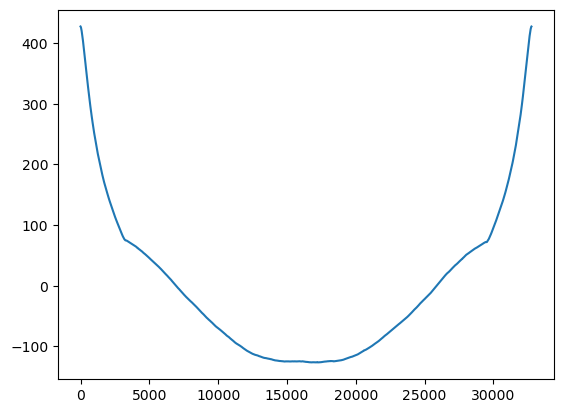

In [66]:
plt.plot(td_1)

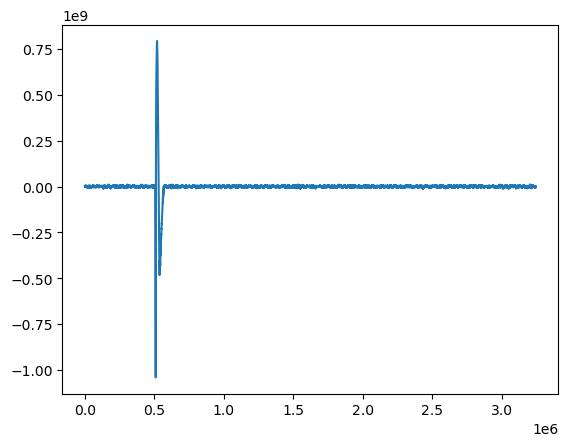

In [68]:
plt.plot(td_2)

In [69]:
max_index = np.argmax(td_2)
print("Index of maximum value:", max_index)
print("Maximum value:", td_2[max_index])

Index of maximum value: 519342
Maximum value: 790640915.8917897


In [70]:
idx

535976

In [78]:
length

32768